In [25]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
def f(x):
    return 3*x**2 - 4*x + 5

In [27]:
f(3.0)

20.0

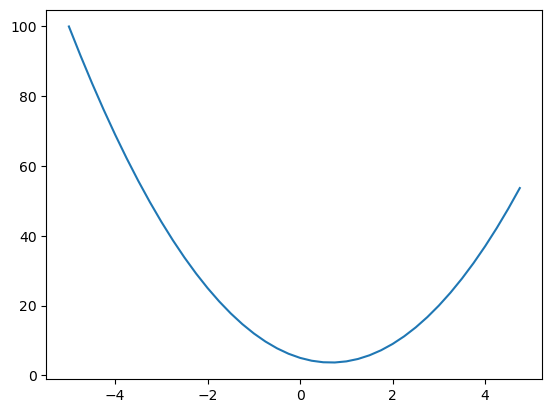

In [28]:
xs  = np.arange(-5, 5, 0.25)
ys  = f(xs)

plt.plot(xs, ys)

In [29]:
h = 0.000000001
x = 2/3
(f(x+h) - f(x)) / h

0.0

In [30]:
# experiment with more complex expressions
a = 2.0
b = 3.0
c = 10.0
d = a*b + c
print(d)

16.0


In [31]:
h= 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c+=h
d2 = a*b + c
print(f"d1: {d1}\nd2: {d2}")
print(f"Slope: {(d2-d1)/h}")

d1: 4.0
d2: 4.0001
Slope: 0.9999999999976694


In [132]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self) -> str:
        return f"Value({self.data})"
    
    def __add__(self, other):
        out =  Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    # def __pow__(self, other):
    #     return Value(self.data ** other.data, (self, other), '^')
    
    # def __sub__(self, other):
    #     return Value(self.data - other.data, (self, other), '-')
    
    # def __neg__(self):
    #     return Value(-self.data, (self,), '-')
    
    # def __truediv__(self, other):
    #     return Value(self.data / other.data, (self, other), '/')
    
    # def exp(self):
    #     return Value(math.exp(self.data), (self,), 'exp')
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n)-1) / (math.exp(2*n)+1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self): # refer to ### Automatic backpropagation cells
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for v in reversed(topo):
            v._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
d = a*b; d.label = 'd'
e = d+c; e.label = 'e'
f = Value(-2.0, label='f')
L = e*f; L.label = 'L'

In [65]:
L._prev

{Value(-2.0), Value(4.0)}

In [66]:
L._op

'*'

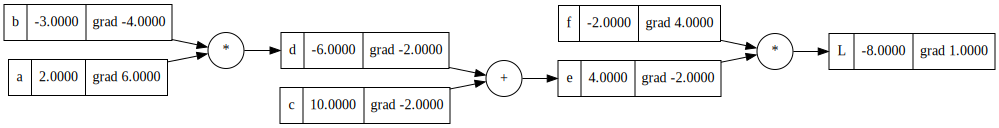

In [101]:
# import graphviz
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ('TB', 'LR')
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a record node
        dot.node(str(id(n)), label="{ %s | %.4f | grad %.4f }"%(n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(uid+n._op, label=n._op, shape='circle')
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
    return dot

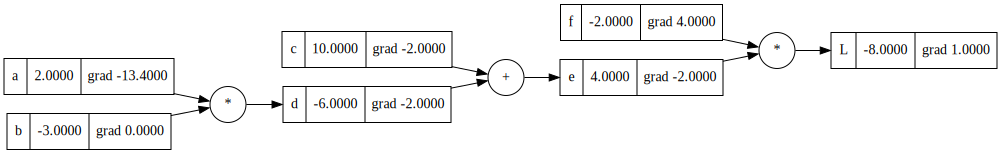

In [107]:
L.grad = 1.0
f.grad = e.data
e.grad = f.data
d.grad = e.grad * 1.0
c.grad = e.grad * 1.0
b.grad = d.grad * a.data
a.grad = d.grad * b.data

draw_dot(L)

In [103]:
def lol():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    d = a*b; d.label = 'd'
    e = d+c; e.label = 'e'
    f = Value(-2.0, label='f')
    L = e*f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a'); a.data += h
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c') 
    d = a*b; d.label = 'd'
    e = d+c; e.label = 'e'  
    f = Value(-2.0, label='f')
    L = e*f; L.label = 'L'
    L2 = L.data

    print(round((L2-L1)/h, 2))
lol()

6.0


### More complex, neuron- mlp

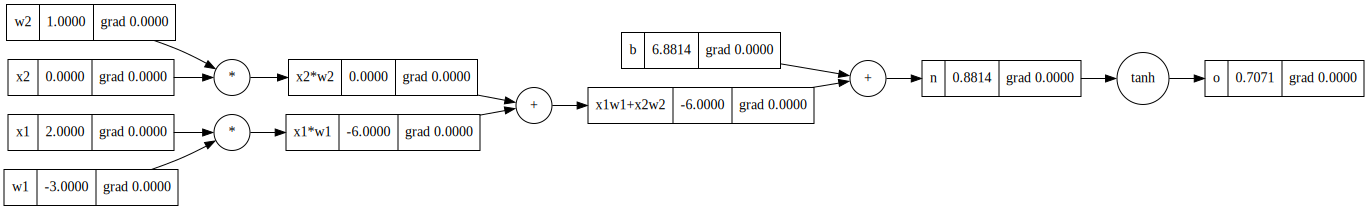

In [134]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias b
b = Value(6.8813835870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = 'x1w1+x2w2'
n = x1w1_x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
draw_dot(o)


In [135]:
# manual backward propagation
# o.grad = 1.0
# n.grad = (1-o.data**2)
# b.grad = n.grad * 1.0
# x1w1_x2w2.grad = n.grad * 1.0
# x2w2.grad = x1w1_x2w2.grad * 1.0
# x1w1.grad = x1w1_x2w2.grad * 1.0
# w1.grad = x1w1.grad * x1.data
# x1.grad = x1w1.grad * w1.data
# w2.grad = x2w2.grad * x2.data
# x2.grad = x2w2.grad * w2.data

# draw_dot(o)


In [136]:
# codified backward propagation
# o.grad = 1.0
# o._backward()
# n._backward()
# b._backward()
# x1w1_x2w2._backward()
# x2w2._backward()
# x1w1._backward()

# draw_dot(o)

### Automatic backpropagation

In [137]:
# Implemented as the Value.backward
# # Topological sort
# def sort_topo(root):
#     visited = set()
#     order = []
#     def build(v):
#         if v not in visited:
#             visited.add(v)
#             for child in v._prev:
#                 build(child)
#             order.append(v)
#     build(root)
#     return order

# topo_o = sort_topo(o)
# print([v.label for v in topo_o])

# for v in reversed(topo_o):
#     v._backward()

# draw_dot(o)

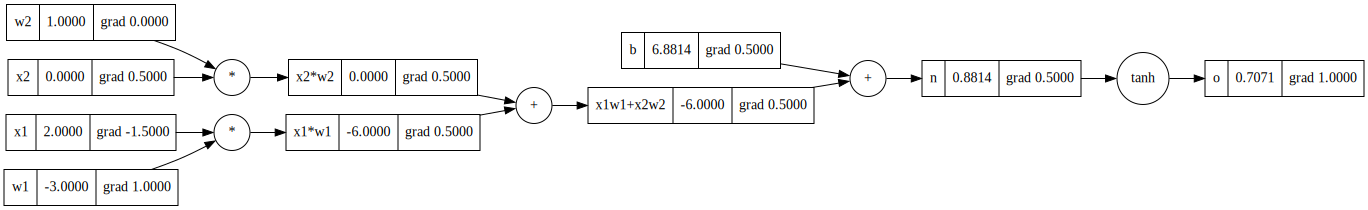

In [138]:
o.backward()

draw_dot(o)

In [140]:
def lol():
    x1 = Value(2.0)
    x2 = Value(0.0)
    # weights w1, w2
    w1 = Value(-3.0)
    w2 = Value(1.0)
    # bias b
    b = Value(6.8813835870195432)
    # x1*w1 + x2*w2 + b
    x1w1 = x1*w1
    x2w2 = x2*w2
    x1w1_x2w2 = x1w1 + x2w2
    n = x1w1_x2w2 + b
    o = n.tanh()
    L1 = o.data

    # uncomment += h section for the desired variable
    x1 = Value(2.0) # ; x1.data += h
    x2 = Value(0.0) # ; x2.data += h
    w1 = Value(-3.0) # ; w1.data += h
    w2 = Value(1.0) # ; w2.data += h
    b = Value(6.8813835870195432) # ; b.data += h
    x1w1 = x1*w1
    x2w2 = x2*w2
    x1w1_x2w2 = x1w1 + x2w2
    n = x1w1_x2w2 + b
    o = n.tanh()
    L2 = o.data

    print(round((L2-L1)/h, 2))

lol()

0.0


### More activation functions

In [ ]:
# ReLU
def relu(x):
    return max(0, x)

# ReLU derivative
def drelu(x):
    return 1.0 if x > 0 else 0.0